# ***Bitcoin Stock Price Prediction using LSTM***

## ***1. Importing Libraries***

In [1]:
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
from numpy import array

## ***2. Loading Dataset***

In [2]:
df = pd.read_csv('dataset/BTC-USD.csv')

In [3]:
print('Total number of days present in the dataset: ',df.shape[0])
print('Total number of fields present in the dataset: ',df.shape[1])

Total number of days present in the dataset:  2713
Total number of fields present in the dataset:  7


In [4]:
df.shape

(2713, 7)

In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [6]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2713.000000,2713.000000,2713.000000,2713.000000,2713.000000,2.713000e+03
mean,11311.041069,11614.292482,10975.555057,11323.914637,11323.914637,1.470462e+10
std,16106.428891,16537.390649,15608.572560,16110.365010,16110.365010,2.001627e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,606.396973,609.260986,604.109985,606.718994,606.718994,7.991080e+07
50%,6301.569824,6434.617676,6214.220215,6317.609863,6317.609863,5.098183e+09
75%,10452.399414,10762.644531,10202.387695,10462.259766,10462.259766,2.456992e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


#### ***Checking for NULL Values***

In [7]:
print('Null Values:',df.isnull().values.sum())
print('NA values:',df.isnull().values.any())

Null Values: 0
NA values: False


## ***3. EDA (Exploratory Data Analysis***

In [8]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

y_overall = df.loc[(df['Date'] >= '2014-09-17')
                     & (df['Date'] <= '2022-02-19')]

y_overall.drop(y_overall[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
0,2014-09-17,465.864014,468.174011,452.421997,457.334015
1,2014-09-18,456.859985,456.859985,413.104004,424.440002
2,2014-09-19,424.102997,427.834991,384.532013,394.795990
3,2014-09-20,394.673004,423.295990,389.882996,408.903992
4,2014-09-21,408.084991,412.425995,393.181000,398.821014
...,...,...,...,...,...
2708,2022-02-15,42586.464844,44667.218750,42491.035156,44575.203125
2709,2022-02-16,44578.277344,44578.277344,43456.691406,43961.859375
2710,2022-02-17,43937.070313,44132.972656,40249.371094,40538.011719
2711,2022-02-18,40552.132813,40929.152344,39637.617188,40030.976563


In [9]:
monthvise= y_overall.groupby(y_overall['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,12855.131425,12828.374881
February,12773.077824,12837.802432
March,10918.895761,10957.226324
April,11338.448900,11359.962198
May,10659.455257,10580.209317
June,9299.305977,9294.420703
July,9285.402500,9330.128271
August,11312.971706,11345.157739
September,10489.365578,10462.378150


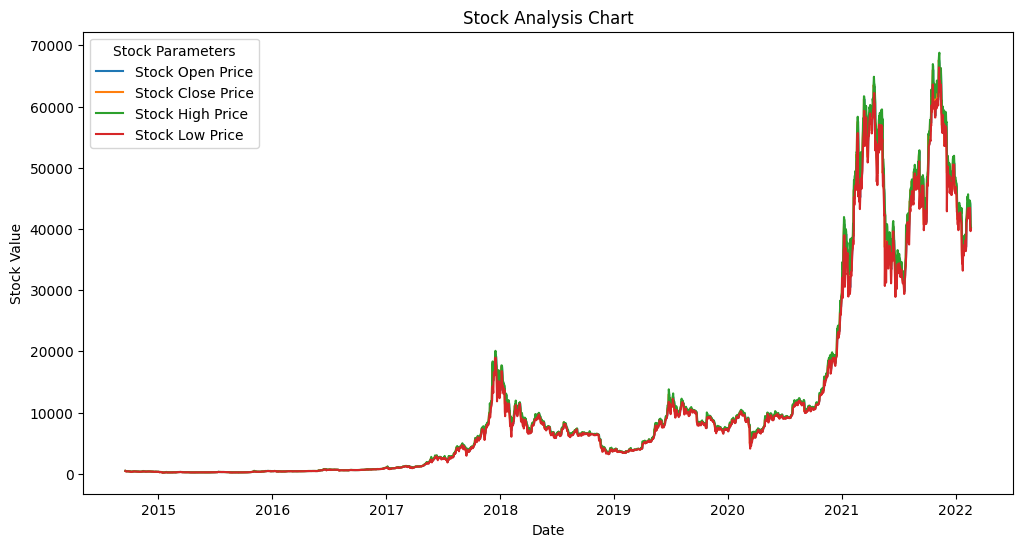

In [10]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=y_overall, x='Date', y='Open', label='Stock Open Price')
sns.lineplot(data=y_overall, x='Date', y='Close', label='Stock Close Price')
sns.lineplot(data=y_overall, x='Date', y='High', label='Stock High Price')
sns.lineplot(data=y_overall, x='Date', y='Low', label='Stock Low Price')

plt.title('Stock Analysis Chart')
plt.xlabel('Date')
plt.ylabel('Stock Value')
plt.legend(title='Stock Parameters')
plt.show()

## ***4. Model Building***

In [11]:
# Lets First Take all the Close Price 
closedf = df[['Date','Close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (2713, 2)


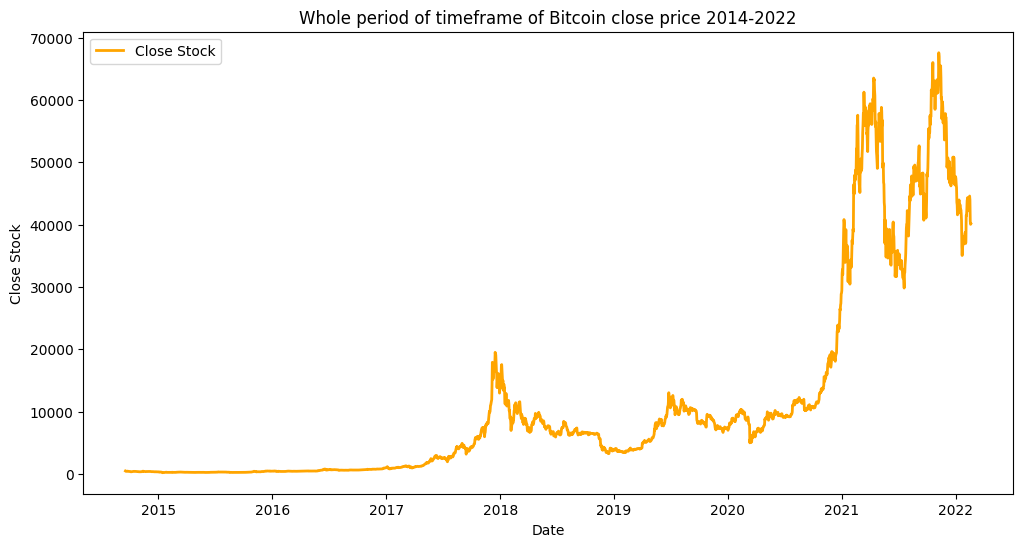

In [12]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=closedf, x='Date', y='Close', color='orange', linewidth=2, label='Close Stock')

plt.title('Whole period of timeframe of Bitcoin close price 2014-2022')
plt.xlabel('Date')
plt.ylabel('Close Stock')
plt.show()

#### ***Now let's consider data for only one year alone***

In [13]:
closedf = closedf[closedf['Date'] > '2021-02-19']
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  365


In [14]:
closedf

,Date,Close
2348,2021-02-20,56099.519531
2349,2021-02-21,57539.945313
2350,2021-02-22,54207.320313
2351,2021-02-23,48824.425781
2352,2021-02-24,49705.332031
...,...,...
2708,2022-02-15,44575.203125
2709,2022-02-16,43961.859375
2710,2022-02-17,40538.011719
2711,2022-02-18,40030.976563


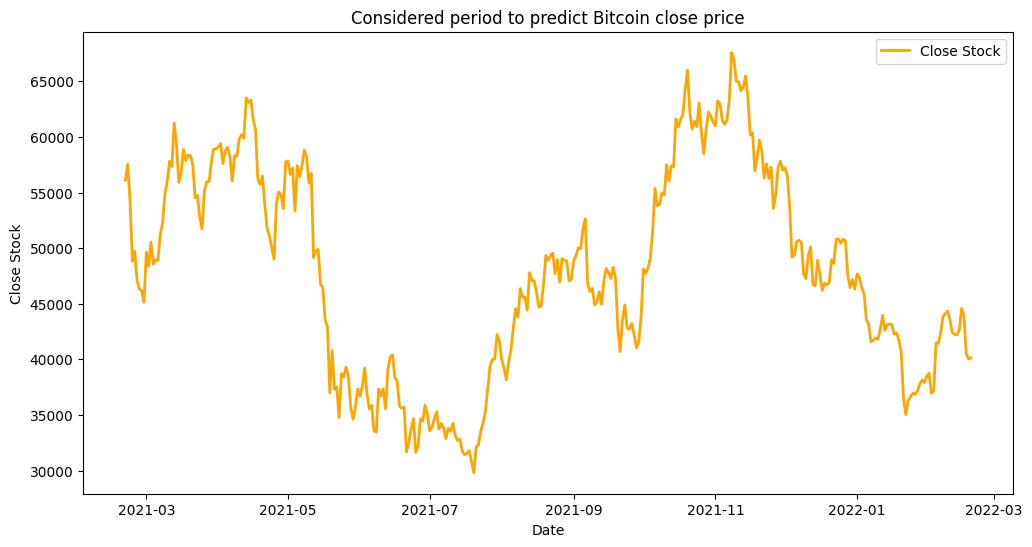

In [15]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=closedf, x='Date', y='Close', color='orange', linewidth=2, label='Close Stock')

plt.title('Considered period to predict Bitcoin close price')
plt.xlabel('Date')
plt.ylabel('Close Stock')
plt.show()

####  ***Normalizing Data***

In [16]:
# deleting date column and normalizing using MinMax Scaler

del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(365, 1)


#### ***Splitting the training and testing data***

In [17]:
# training set - 60% and testing set - 40%

training_size=int(len(closedf)*0.60)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (219, 1)
test_data:  (146, 1)


In [18]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [19]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (203, 15)
y_train:  (203,)
X_test:  (130, 15)
y_test (130,)


In [20]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (203, 15, 1)
X_test:  (130, 15, 1)


In [21]:
#Creating the LSTM model

model=Sequential()
model.add(LSTM(10,input_shape=(None,1),activation="relu"))
model.add(Dense(1))
model.compile(loss="mean_squared_error",optimizer="adam")

In [22]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1)

Epoch 1/200

7/7 [==============================] - 1s 30ms/step - loss: 0.3236 - val_loss: 0.4414
Epoch 2/200
7/7 [==============================] - 0s 6ms/step - loss: 0.2627 - val_loss: 0.3590
Epoch 3/200
7/7 [==============================] - 0s 6ms/step - loss: 0.2104 - val_loss: 0.2874
Epoch 4/200
7/7 [==============================] - 0s 6ms/step - loss: 0.1659 - val_loss: 0.2209
Epoch 5/200
7/7 [==============================] - 0s 6ms/step - loss: 0.1238 - val_loss: 0.1599
Epoch 6/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0875 - val_loss: 0.1082
Epoch 7/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0588 - val_loss: 0.0672
Epoch 8/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0360 - val_loss: 0.0341
Epoch 9/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0215 - val_loss: 0.0140
Epoch 10/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0153 - val_loss: 0.0100
Epoch 11/200
7/7 [=========

## ***5. Visualizing Loss***

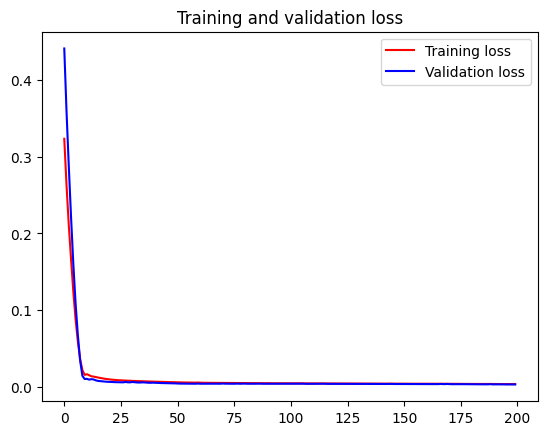

<Figure size 640x480 with 0 Axes>

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

## ***6. Making Pedictions***

In [24]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

5/5 [==============================] - 0s 998us/step


((203, 1), (130, 1))

## ***7. Model Evaluation***

In [25]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

#### ***Evaluation Metrics - MSE, RMSE, MAE***

In [26]:
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  2148.275566152349
Train data MSE:  4615087.908127194
Train data MAE:  1721.4519993269705
-------------------------------------------------------------------------------------
Test data RMSE:  2010.7157125895046
Test data MSE:  4042977.676854319
Test data MAE:  1568.5689002653842


## ***8. Comparing Actual vs Predicted Stock Price***

Train predicted data:  (365, 1)
Test predicted data:  (365, 1)


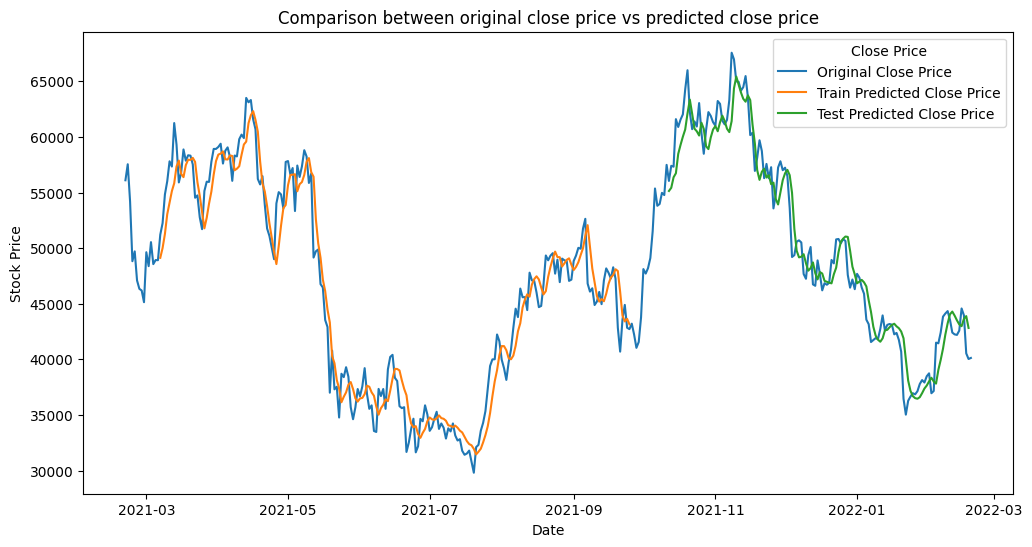

In [27]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

plt.figure(figsize=(12, 6))
sns.lineplot(data=plotdf, x='date', y='original_close', label='Original Close Price')
sns.lineplot(data=plotdf, x='date', y='train_predicted_close', label='Train Predicted Close Price')
sns.lineplot(data=plotdf, x='date', y='test_predicted_close', label='Test Predicted Close Price')

plt.title('Comparison between original close price vs predicted close price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend(title='Close Price')
plt.show()